##AASHI AGGARWAL
##8920299

##Installing all libraries

In [11]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pathlib
import matplotlib.pyplot as plt
import os
import shutil
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve, auc
from keras.utils import to_categorical
from sklearn.preprocessing import label_binarize
from collections import Counter
from keras.optimizers import Adam


##Setting path

In [12]:
# Get dataset
# Setting their path

train_folder = pathlib.Path("C:/Users/Andy/Desktop/ML/CSCN8010-lab-submissions/students_submissions/8920299/lab10/train")
test_folder = pathlib.Path('C:/Users/Andy/Desktop/ML/CSCN8010-lab-submissions/students_submissions/8920299/lab10/test')
valid_folder = pathlib.Path('C:/Users/Andy/Desktop/ML/CSCN8010-lab-submissions/students_submissions/8920299/lab10/valid')


##Creating function to Identify top 3 classes.

In [13]:
# Identify Top 3 Classes
def count_images_per_class(directory):
    class_counts = Counter()
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            num_images = len(os.listdir(class_path))
            class_counts[class_name] = num_images
    return class_counts


class_counts = count_images_per_class(train_folder)
print(len(class_counts))
top_3_class = sorted(class_counts, key=class_counts.get, reverse=True)[:3]
print("Top 3 Classes:", top_3_class)

3
Top 3 Classes: ['RUFOUS TREPE', 'HOUSE FINCH', 'D-ARNAUDS BARBET']


In [14]:
# delete the folders that are not top 3 class so that dataset is organized and limited to what we need only.


for species in os.listdir(train_folder):
    if species not in top_3_class:
        delete_path_train = os.path.join(train_folder, species)
        shutil.rmtree(delete_path_train)

for species in os.listdir(test_folder):
    if species not in top_3_class:
        delete_path_test = os.path.join(test_folder, species)
        shutil.rmtree(delete_path_test)

for species in os.listdir(valid_folder):
    if species not in top_3_class:
        delete_path_valid = os.path.join(valid_folder, species)
        shutil.rmtree(delete_path_valid)

##2. Use data-augmentation to increase the number of training images. You are encouraged to try out various augmentation methods supported by Keras. The rule of thumb is that as long as an augmentation produces realistic images - it is probably a good idea to add it.(2 point)

In [15]:
# Storing all datasets in list to iterate
folders = [train_folder, valid_folder, test_folder]

datasets = []

# Looping through datasets and appending in empty list
for folder in folders:
    dataset = image_dataset_from_directory(
        directory=folder,
        image_size=(224, 224),
        batch_size=32
    )
    datasets.append(dataset)

# Unpack datasets into individual variables
train_dataset, validation_dataset, test_dataset = datasets


Found 744 files belonging to 3 classes.
Found 15 files belonging to 3 classes.
Found 15 files belonging to 3 classes.


In [16]:
from keras.preprocessing.image import ImageDataGenerator

# Define data augmentation parameters
data_generator_params = {
    'horizontal_flip': True,
    'fill_mode': 'nearest'
}

# Create ImageDataGenerator instance
data_generator = ImageDataGenerator(**data_generator_params )

# Define common generator parameters
generator_params = {
    'target_size': (224, 224),
    'batch_size': 32,
    'class_mode': 'categorical'
}

# Create generators for training and validation
train_generator = data_generator.flow_from_directory(
    directory=train_folder,
    **generator_params
)

validation_generator = data_generator.flow_from_directory(
    directory=valid_folder,
    **generator_params
)


Found 744 images belonging to 3 classes.
Found 15 images belonging to 3 classes.


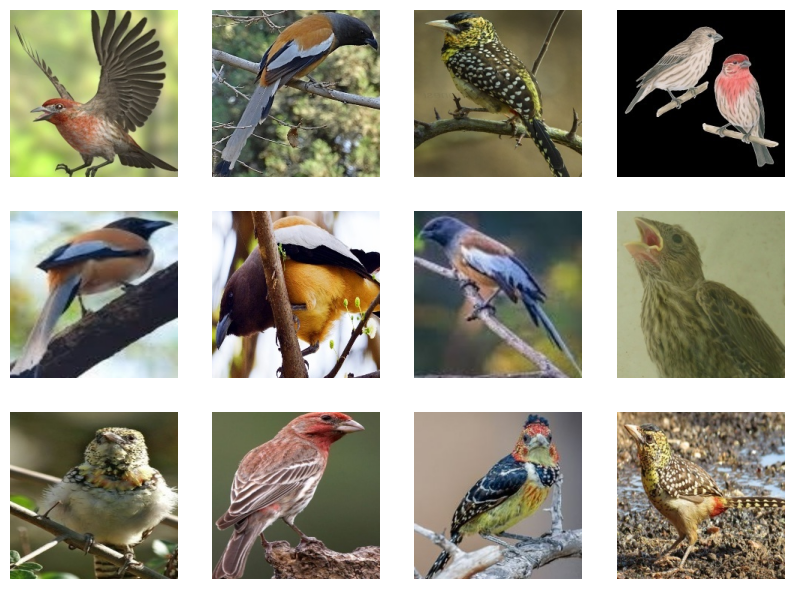

In [17]:

# Number of images to display
num_images = 12

# Fetch few 
images, _ = next(train_generator)

# Plot the images
plt.figure(figsize=(10, 10))

for i in range(num_images):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].astype("uint8"))
    plt.axis("off")

plt.show()


##3. Fine-Tune `VGG16` (pre-trained on `imagenet`), to classify the 3 classes (2 points)

In [18]:
# load pre-trained VGG16 model
model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
model.summary()


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [19]:
# Existing code
x = model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)

# New custom layers
dense_layer = Dense(512, activation='relu')
dropout_layer = layers.Dropout(0.5)

# Connect the new layers
x = dense_layer(x)
x = dropout_layer(x)

# Output layer for 3 classes
predictions = Dense(3, activation='softmax')(x)

# Create the model
modell = Model(inputs=model.input, outputs=predictions)
modell.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [26]:


# Set the loss function
loss_function = 'categorical_crossentropy'

# Set the optimizer
optimizer = Adam()

# Set the metrics
model_metrics = ['accuracy']

#To make the data compatible for fine tuning
model.trainable = False


# Compile the model
modell.compile(loss=loss_function, optimizer=optimizer, metrics=model_metrics)


In [27]:
history = modell.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

Epoch 1/10
24/24 [==============================] - 56s 2s/step - loss: 2.1261 - accuracy: 0.7957 - val_loss: 0.1211 - val_accuracy: 0.9333
Epoch 2/10
24/24 [==============================] - 54s 2s/step - loss: 0.3775 - accuracy: 0.9341 - val_loss: 1.9286e-05 - val_accuracy: 1.0000
Epoch 3/10
24/24 [==============================] - 54s 2s/step - loss: 0.2775 - accuracy: 0.9556 - val_loss: 1.4326e-04 - val_accuracy: 1.0000
Epoch 4/10
24/24 [==============================] - 55s 2s/step - loss: 0.2690 - accuracy: 0.9597 - val_loss: 0.0137 - val_accuracy: 1.0000
Epoch 5/10
24/24 [==============================] - 55s 2s/step - loss: 0.2499 - accuracy: 0.9637 - val_loss: 9.1046e-04 - val_accuracy: 1.0000
Epoch 6/10
24/24 [==============================] - 55s 2s/step - loss: 0.1441 - accuracy: 0.9758 - val_loss: 0.0025 - val_accuracy: 1.0000
Epoch 7/10
24/24 [==============================] - 56s 2s/step - loss: 0.2076 - accuracy: 0.9704 - val_loss: 8.1791e-05 - val_accuracy: 1.0000
Epoc

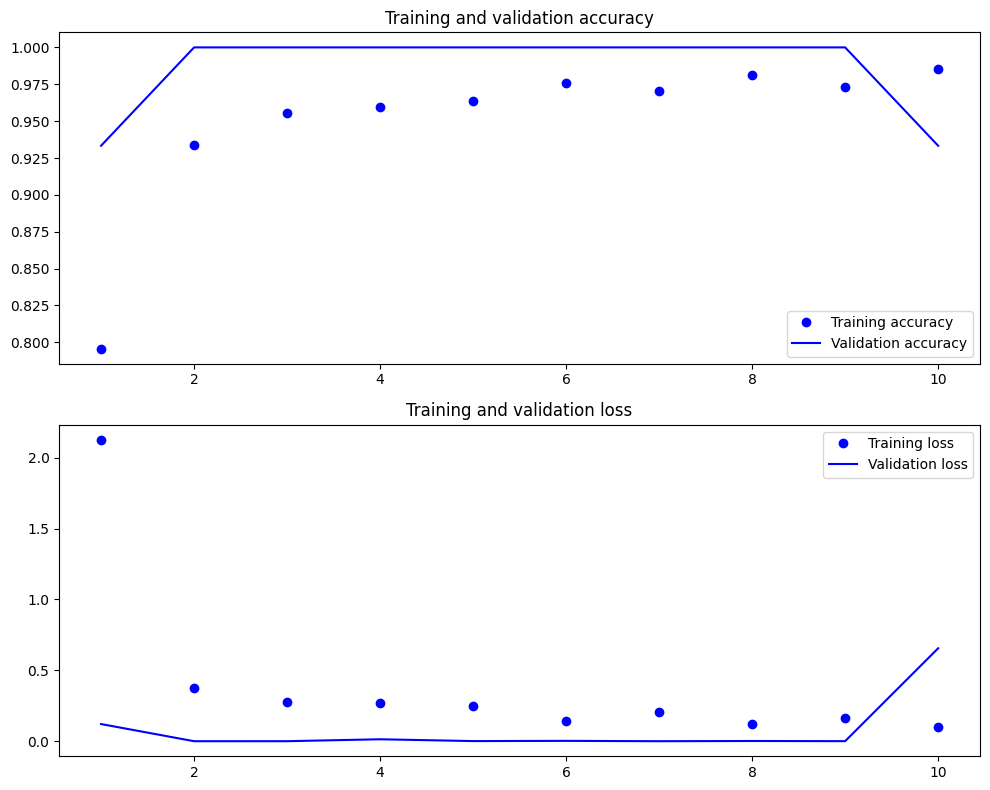

In [28]:
# Assuming 'history' is previously defined
epochs = range(1, len(history.history["accuracy"]) + 1)

# Create a figure with two subplots
fig = plt.figure(figsize=(10, 8))

# Plot training and validation accuracy
ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(epochs, history.history["accuracy"], "bo", label="Training accuracy")
ax1.plot(epochs, history.history["val_accuracy"], "b", label="Validation accuracy")
ax1.set_title("Training and validation accuracy")
ax1.legend()

# Plot training and validation loss
ax2 = fig.add_subplot(2, 1, 2)
ax2.plot(epochs, history.history["loss"], "bo", label="Training loss")
ax2.plot(epochs, history.history["val_loss"], "b", label="Validation loss")
ax2.set_title("Training and validation loss")
ax2.legend()

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


##Testing Accuracy

In [30]:
test_loss, test_acc = modell.evaluate(validation_generator)
print(f"Test accuracy: {test_acc:.3f}")

1/1 [==============================] - 1s 1s/step - loss: 0.3536 - accuracy: 0.9333
Test accuracy: 0.933


In [32]:
# Confusion matrix, Precision, Recall and F1-score
y_pred = modell.predict(validation_generator)
y_pred_class = np.argmax(y_pred, axis=1)

y_true = validation_generator.classes

# confusion matrix
cm = confusion_matrix(y_true, y_pred_class)

# precision, recall and F1-score
print(classification_report(y_true, y_pred_class, target_names=validation_generator.class_indices.keys()))

1/1 [==============================] - 1s 1s/step
                  precision    recall  f1-score   support

D-ARNAUDS BARBET       0.25      0.20      0.22         5
     HOUSE FINCH       0.60      0.60      0.60         5
    RUFOUS TREPE       0.33      0.40      0.36         5

        accuracy                           0.40        15
       macro avg       0.39      0.40      0.40        15
    weighted avg       0.39      0.40      0.40        15

